In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [55]:
import pandas as pd
df = pd.read_csv('2019_hdb_dataset_with_mrt_schools_sm.csv')
# df = df.drop(columns = ['Unnamed: 0','Latitude','Longtitude','Year','address','nearest_mrt','nearest_primary_school','nearest_secondary_school','nearest_JC/MI','nearest_mixed_level','nearest_sm','Postal','remaining_lease','full_address'])
df = df.drop(columns = ['Unnamed: 0','Year','address','Postal','full_address'])
df['remaining_lease'] = 99 - (2019 - df['lease_commence_date'])
df['flat_type_model'] = df['flat_type']+' '+df['flat_model']
df = df.drop(columns = ['flat_type','flat_model'])

In [56]:
# turn all towns into their respective region, then turn it into nominal values afterwards for easy modelling.
df['region'] = df['town'].map({'ANG MO KIO':'North_East',
                             'BEDOK': 'East',
                             'BISHAN':'Central',
                             'BUKIT BATOK':'West',
                             'BUKIT MERAH':'Central',                 
                             'BUKIT PANJANG':'West',
                             'BUKIT TIMAH':'Central',
                             'CENTRAL AREA':'Central',
                             'CHOA CHU KANG':'West',
                             'CLEMENTI':'West',
                             'GEYLANG':'Central',
                             'HOUGANG':'North_East',
                             'JURONG EAST':'West',
                             'JURONG WEST':'West',
                             'KALLANG/WHAMPOA':'Central',
                             'MARINE PARADE':'Central',
                             'PASIR RIS': 'East',
                             'PUNGGOL':'North_East',
                             'QUEENSTOWN':'Central',
                             'SEMBAWANG': 'North',
                             'SENGKANG':'North_East',
                             'SERANGOON':'North_East',
                             'TAMPINES': 'East',
                             'TOA PAYOH':'Central',
                             'WOODLANDS': 'North',
                             'YISHUN': 'North'})
df['region_encoded'] = df['region'].map({'West':1,'North':2, 'North_East':3,'East':4,'Central':5})

In [57]:
from sklearn.preprocessing import LabelEncoder
# Process columns and apply LabelEncoder to categorical features
lbl = LabelEncoder() 
lbl.fit(list(df['storey_range'].values)) 
df['storey_range'] = lbl.transform(list(df['storey_range'].values))

lbl.fit(list(df['storey_range'].values)) 
df['storey_range'] = lbl.transform(list(df['storey_range'].values))

# Check shape        
print('Shape all_data: {}'.format(df.shape))

Shape all_data: (22186, 23)


In [58]:
# remove town and region since we won't need it anymore.
df = df.drop(columns = ['town','region'])
# all_data.head()

In [59]:
df

,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,Latitude,Longtitude,nearest_mrt,nearest_mrt_distance_km,nearest_primary_school,...,nearest_secondary_school,nearest_secondary_school_km,nearest_JC/MI,nearest_JC_MI_km,nearest_mixed_level,nearest_mixed_level_km,nearest_sm,nearest_sm_distance_km,flat_type_model,region_encoded
0,0,68.000,1981,61,270000.000,1.362,103.851,ANG MO KIO MRT STATION,0.846,TECK GHEE PRIMARY SCHOOL,...,DEYI SECONDARY SCHOOL,0.553,EUNOIA JUNIOR COLLEGE,1.174,CATHOLIC HIGH SCHOOL,1.084,G8 MART PTE. LTD.,0.391,3 ROOM New Generation,3
1,1,73.000,1976,56,295000.000,1.367,103.842,ANG MO KIO MRT STATION,0.958,ANG MO KIO PRIMARY SCHOOL,...,ANG MO KIO SECONDARY SCHOOL,0.140,EUNOIA JUNIOR COLLEGE,0.471,CHIJ ST. NICHOLAS GIRLS' SCHOOL,1.136,NTUC Fairprice Co-operative Ltd,0.000,3 ROOM New Generation,3
2,2,67.000,1978,58,270000.000,1.367,103.838,ANG MO KIO MRT STATION,1.300,ANG MO KIO PRIMARY SCHOOL,...,MAYFLOWER SECONDARY SCHOOL,0.319,EUNOIA JUNIOR COLLEGE,0.605,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.820,SHENG SIONG SUPERMARKET PTE LTD,0.158,3 ROOM New Generation,3
3,0,67.000,1978,58,230000.000,1.367,103.838,ANG MO KIO MRT STATION,1.300,ANG MO KIO PRIMARY SCHOOL,...,MAYFLOWER SECONDARY SCHOOL,0.319,EUNOIA JUNIOR COLLEGE,0.605,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.820,SHENG SIONG SUPERMARKET PTE LTD,0.158,3 ROOM New Generation,3
4,0,68.000,1981,61,262500.000,1.361,103.852,ANG MO KIO MRT STATION,0.979,TOWNSVILLE PRIMARY SCHOOL,...,DEYI SECONDARY SCHOOL,0.665,EUNOIA JUNIOR COLLEGE,1.254,CATHOLIC HIGH SCHOOL,1.045,G8 MART PTE. LTD.,0.469,3 ROOM New Generation,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22181,1,142.000,1988,68,580000.000,1.430,103.842,YISHUN MRT STATION,0.828,HUAMIN PRIMARY SCHOOL,...,YISHUN TOWN SECONDARY SCHOOL,0.597,YISHUN INNOVA JUNIOR COLLEGE,1.526,SINGAPORE SPORTS SCHOOL,5.909,TAN KWEE ENG,0.058,EXECUTIVE Apartment,2
22182,2,146.000,1988,68,565000.000,1.430,103.842,YISHUN MRT STATION,0.828,HUAMIN PRIMARY SCHOOL,...,YISHUN TOWN SECONDARY SCHOOL,0.597,YISHUN INNOVA JUNIOR COLLEGE,1.526,SINGAPORE SPORTS SCHOOL,5.909,TAN KWEE ENG,0.058,EXECUTIVE Maisonette,2
22183,0,164.000,1992,72,633000.000,1.421,103.835,KHATIB MRT STATION,0.451,NORTHLAND PRIMARY SCHOOL,...,CHUNG CHENG HIGH SCHOOL (YISHUN),0.324,YISHUN INNOVA JUNIOR COLLEGE,0.753,SINGAPORE SPORTS SCHOOL,5.133,KAI SOON SUPERMARKET PTE. LTD.,0.300,EXECUTIVE Apartment,2
22184,3,164.000,1992,72,788888.000,1.422,103.836,KHATIB MRT STATION,0.557,NORTHLAND PRIMARY SCHOOL,...,CHUNG CHENG HIGH SCHOOL (YISHUN),0.383,YISHUN INNOVA JUNIOR COLLEGE,0.732,SINGAPORE SPORTS SCHOOL,5.158,KAI SOON SUPERMARKET PTE. LTD.,0.300,EXECUTIVE Apartment,2


In [24]:
x = df
y = df['flat_type_model']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
random_state = 1)
train = x_train
test = x_test

In [25]:
df = df.sample(frac=1).reset_index(drop=True)
# shuffled the dataframe to help split train and test datasets later
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

In [26]:
df.head()

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,Latitude,Longtitude,nearest_mrt,nearest_mrt_distance_km,...,nearest_primary_school_km,nearest_secondary_school,nearest_secondary_school_km,nearest_JC/MI,nearest_JC_MI_km,nearest_mixed_level,nearest_mixed_level_km,nearest_sm,nearest_sm_distance_km,flat_type_model
0,SEMBAWANG,13 TO 15,113.000,2001,81,455000.000,1.450,103.819,SEMBAWANG MRT STATION,0.213,...,0.310,CANBERRA SECONDARY SCHOOL,0.567,YISHUN INNOVA JUNIOR COLLEGE,3.100,SINGAPORE SPORTS SCHOOL,4.198,NTUC Fairprice Co-operative Ltd,0.095,5 ROOM Improved
1,JURONG WEST,10 TO 12,93.000,2015,95,448000.000,1.343,103.714,LAKESIDE MRT STATION,0.761,...,0.148,YUAN CHING SECONDARY SCHOOL,0.711,MILLENNIA INSTITUTE,3.149,RIVER VALLEY HIGH SCHOOL,0.709,NTUC Fairprice Co-operative Ltd,0.446,4 ROOM Model A
2,ANG MO KIO,01 TO 03,82.000,1980,60,313000.000,1.381,103.835,YIO CHU KANG MRT STATION,1.072,...,0.515,YIO CHU KANG SECONDARY SCHOOL,0.766,ANDERSON SERANGOON JUNIOR COLLEGE,1.198,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.781,COLD STORAGE SINGAPORE (1983) PTE LTD,0.860,3 ROOM New Generation
3,BISHAN,04 TO 06,120.000,1986,66,630000.000,1.363,103.835,MARYMOUNT MRT STATION,1.697,...,0.349,MAYFLOWER SECONDARY SCHOOL,0.556,EUNOIA JUNIOR COLLEGE,0.636,CHIJ ST. NICHOLAS GIRLS' SCHOOL,1.150,SHENG SIONG SUPERMARKET PTE LTD,0.511,5 ROOM Improved
4,BUKIT PANJANG,07 TO 09,73.000,1989,69,285000.000,1.374,103.774,PENDING LRT STATION,0.412,...,0.535,ASSUMPTION PATHWAY SCHOOL,0.890,JURONG PIONEER JUNIOR COLLEGE,2.548,NATIONAL JUNIOR COLLEGE,5.859,NTUC Fairprice Co-operative Ltd,0.464,3 ROOM Model A


In [27]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train['resale_price'].describe()

count     17748.000
mean     432758.570
std      153751.475
min      160000.000
25%      320000.000
50%      402000.000
75%      510000.000
max     1205000.000
Name: resale_price, dtype: float64


 mu = 432137.91 and sigma = 153972.22



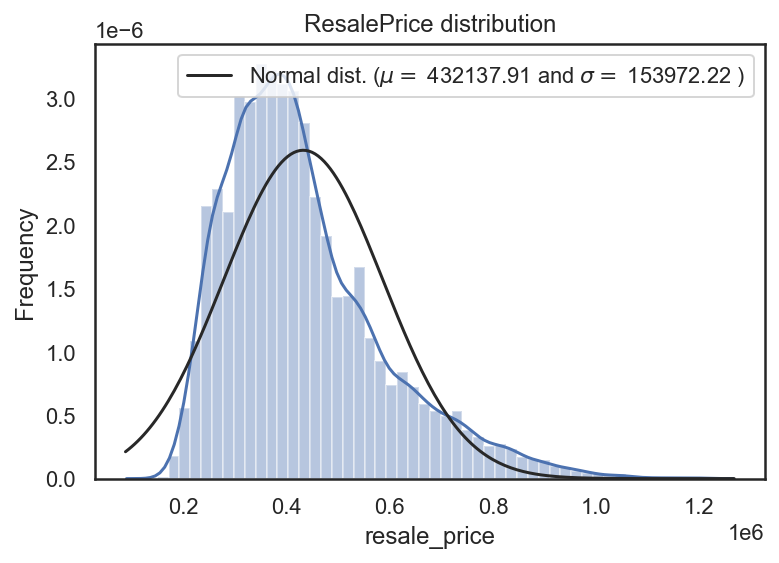

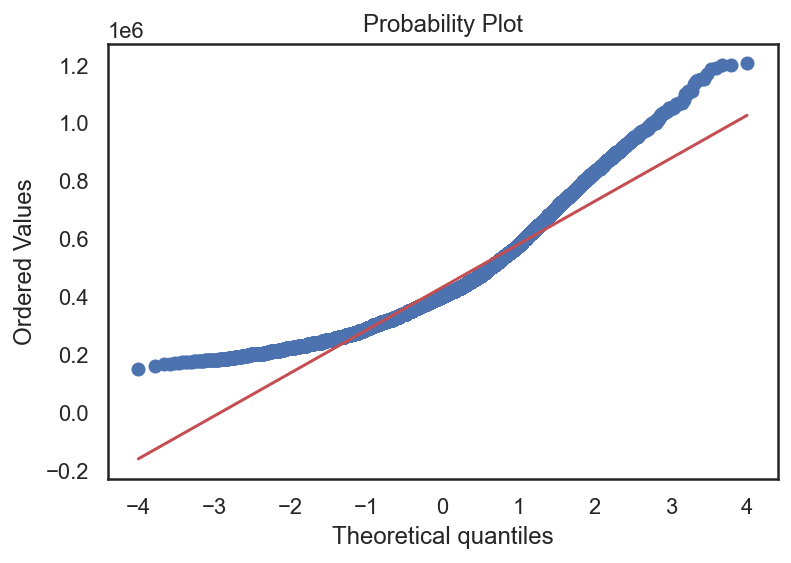

Skewness: 1.103113
Kurtosis: 1.281708


In [28]:
import seaborn as sns
sns.distplot(df['resale_price'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['resale_price'])
# mu refers to mean
# sigma refers to standard deviation
# https://www.quora.com/How-do-you-explain-mu-and-sigma-in-statistics-to-a-layman#:~:text=Mu%20is%20the%20arithmetic%20mean,sigma%20to%20mu%2B2*sigma

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ResalePrice distribution')

fig = plt.figure()
res = stats.probplot(df['resale_price'], plot=plt)
plt.show()

print("Skewness: %f" % df['resale_price'].skew())
print("Kurtosis: %f" % df['resale_price'].kurt())

# Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. 
# That is, data sets with high kurtosis tend to have heavy tails, or outliers. 
# Data sets with low kurtosis tend to have light tails, or lack of outliers. 
# A uniform distribution would be the extreme case.

In [29]:
# multivariate analysis
# checking categorical data
df.select_dtypes(include=['object']).columns

Index(['town', 'storey_range', 'nearest_mrt', 'nearest_primary_school',
       'nearest_secondary_school', 'nearest_JC/MI', 'nearest_mixed_level',
       'nearest_sm', 'flat_type_model'],
      dtype='object')

In [30]:
#Checking numerical data
df.select_dtypes(include=['int64','float64']).columns

Index(['floor_area_sqm', 'lease_commence_date', 'remaining_lease',
       'resale_price', 'Latitude', 'Longtitude', 'nearest_mrt_distance_km',
       'nearest_primary_school_km', 'nearest_secondary_school_km',
       'nearest_JC_MI_km', 'nearest_mixed_level_km', 'nearest_sm_distance_km'],
      dtype='object')

In [31]:
# Total number of features
cat = len(df.select_dtypes(include=['object']).columns)
num = len(df.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  9 categorical + 12 numerical = 21 features


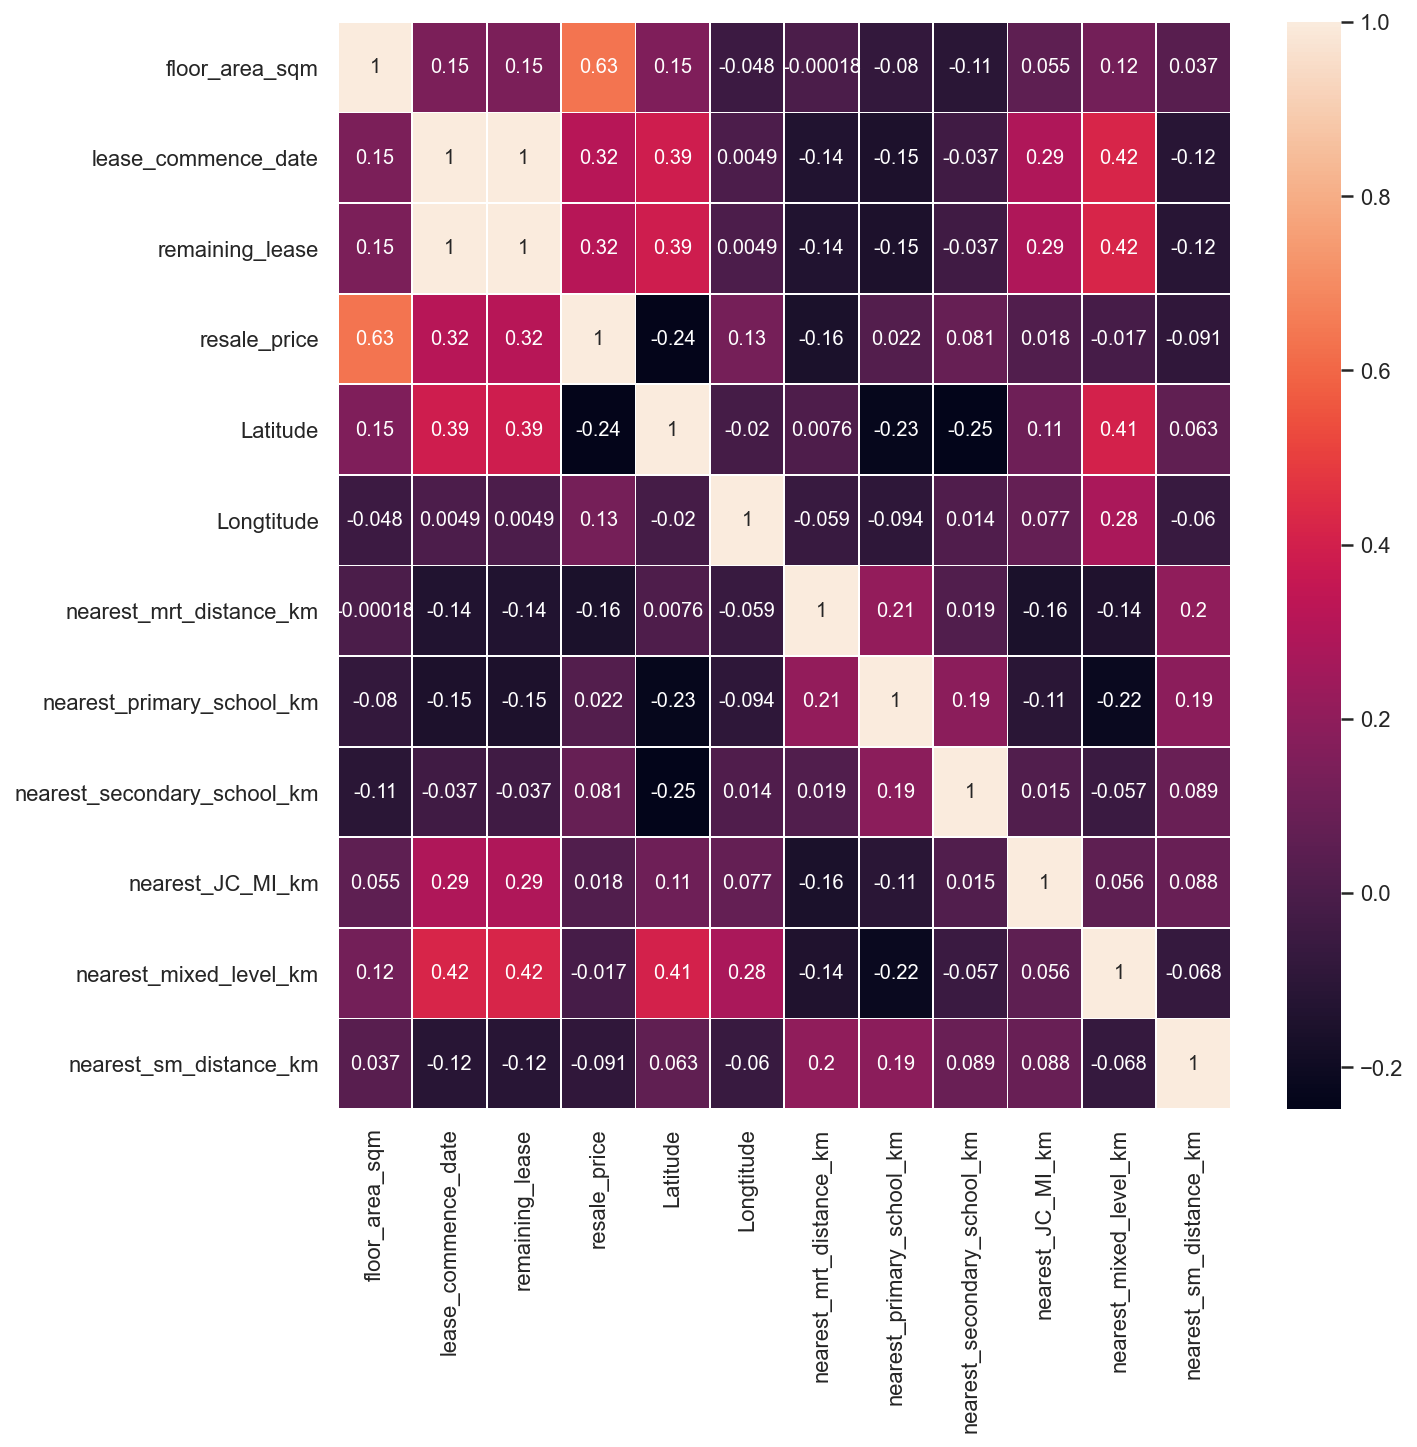

In [32]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax)

In [33]:
# # Ranking the correlated features
# cols = corrmat.nlargest(3, 'resale_price')['resale_price'].index
# most_corr = pd.DataFrame(cols)
# most_corr.columns = ['Most Correlated Features']
# most_corr

NameError: name 'corrmat' is not defined

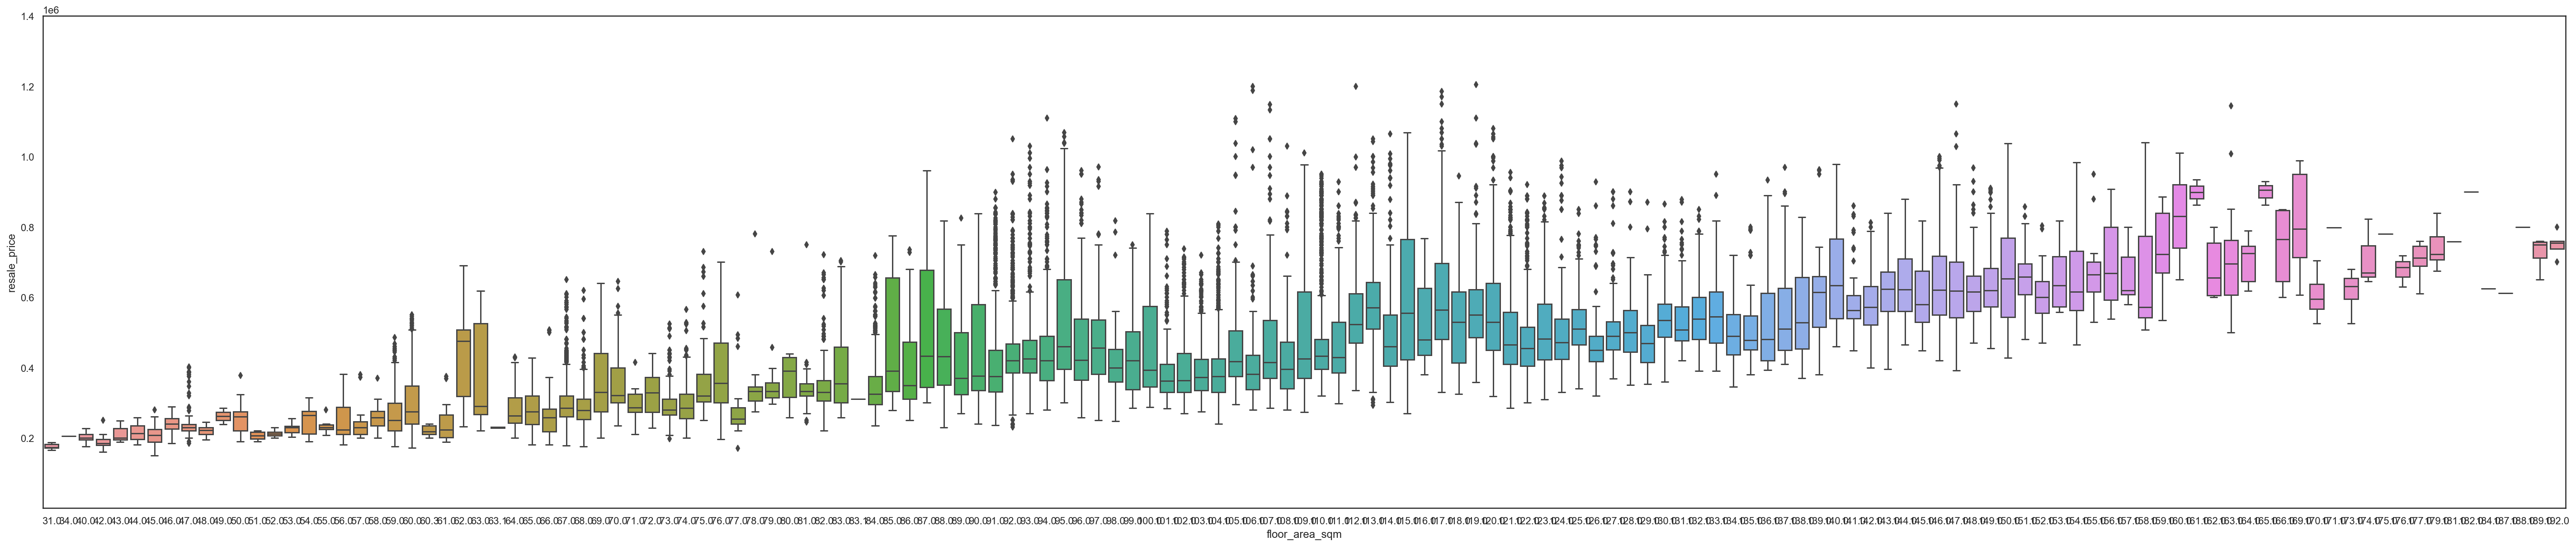

In [35]:
# # floor_area_sqm vs resale_price using box plot
# var = 'floor_area_sqm'
# data = pd.concat([df['resale_price'], df[var]], axis=1)
# f, ax = plt.subplots(figsize=(50, 10))
# fig = sns.boxplot(x=var, y="resale_price", data=data)
# fig.axis(ymin=1000, ymax=1400000);
# # positive correlation: higher price for larger floor area

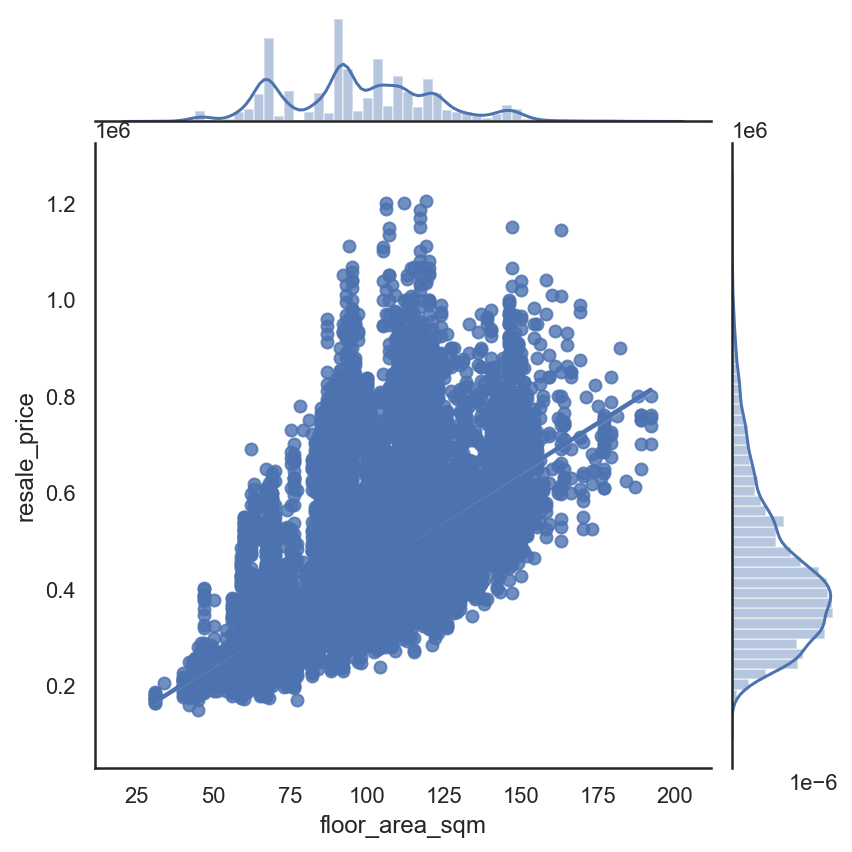

In [36]:
# # floor_area_sqm vs resale_price using joint plot
# sns.jointplot(x=df['floor_area_sqm'], y=df['resale_price'], kind='reg')
# # cannot see pearson r score
# # no need to remove any outlier here i think

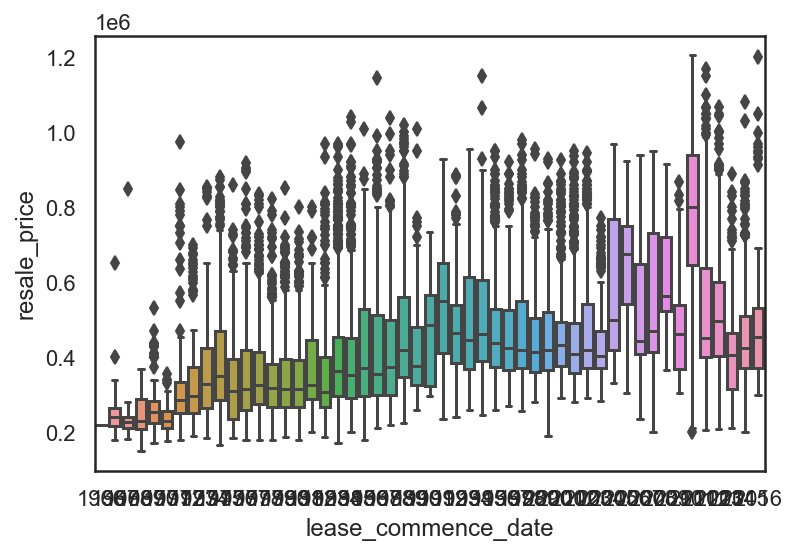

In [37]:
# # lease_commence_date vs resale_price using boxplot
# sns.boxplot(x=df['lease_commence_date'], y=df['resale_price'])
# # increasing through the years? thinking it is more of a categorical variable than numerical?

In [38]:
# Check if there are any missing values in the dataset
target = df.resale_price.values
all_data = df.reset_index(drop=True)
all_data.drop(['resale_price'], axis=1, inplace=True)
print("Train data size is : {}".format(df.shape))
print("New dataset size is : {}".format(all_data.shape))
all_data.isnull().sum()
# no missing data

# Find Missing Ratio of Dataset
# all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
# all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
# missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
# missing_data
# skip because already know there are no missing values

Train data size is : (22186, 21)
New dataset size is : (22186, 20)


town                           0
storey_range                   0
floor_area_sqm                 0
lease_commence_date            0
remaining_lease                0
Latitude                       0
Longtitude                     0
nearest_mrt                    0
nearest_mrt_distance_km        0
nearest_primary_school         0
nearest_primary_school_km      0
nearest_secondary_school       0
nearest_secondary_school_km    0
nearest_JC/MI                  0
nearest_JC_MI_km               0
nearest_mixed_level            0
nearest_mixed_level_km         0
nearest_sm                     0
nearest_sm_distance_km         0
flat_type_model                0
dtype: int64


 mu = 12.92 and sigma = 0.34



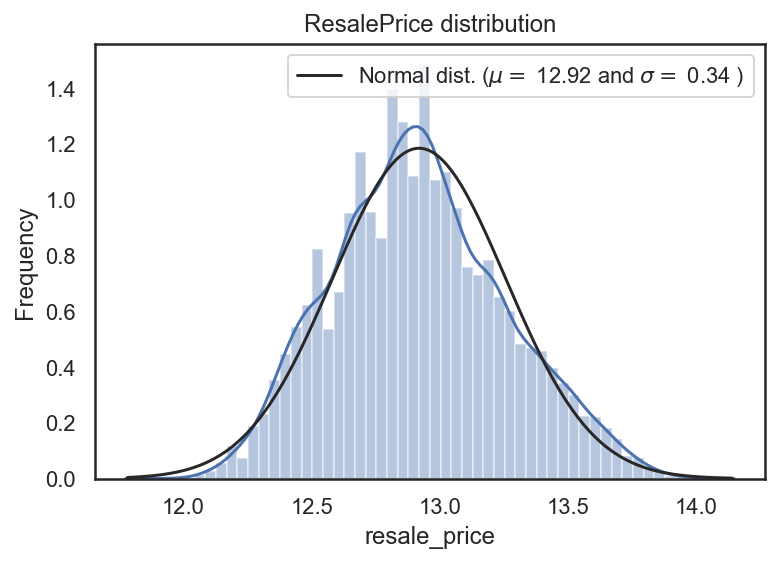

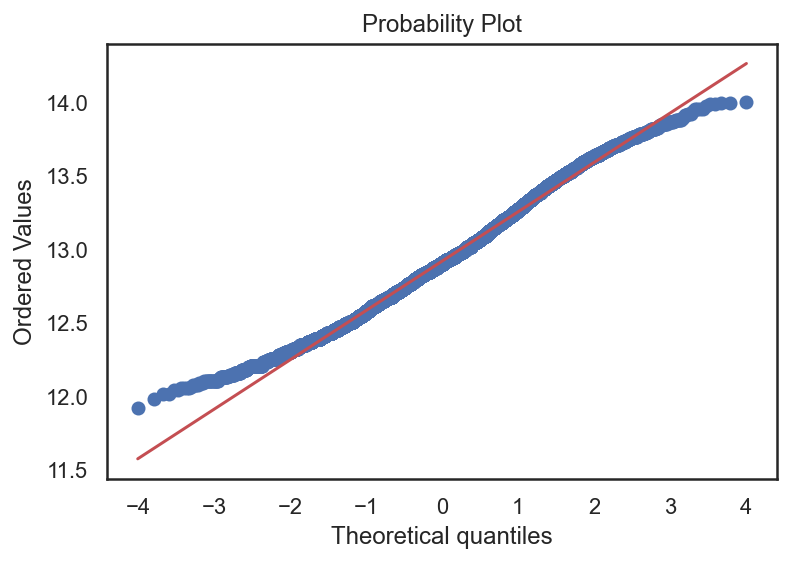

Skewness: 0.233683
Kurtosis: -0.301898


In [39]:
# Fixing skewed features
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["resale_price"] = np.log1p(df["resale_price"])
# use log1p instead of log because more accurate for smaller numbers of x i think, but shouldn't be an issue in this case
# https://stackoverflow.com/questions/49538185/what-is-the-purpose-of-numpy-log1p

#Check the new distribution 
sns.distplot(df["resale_price"], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df["resale_price"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ResalePrice distribution')

fig = plt.figure()
res = stats.probplot(df["resale_price"], plot=plt)
plt.show()

# y_train = df.resale_price.values

print("Skewness: %f" % df["resale_price"].skew())
print("Kurtosis: %f" % df["resale_price"].kurt())
# decreased as compared to the first plot

In [40]:
df['resale_price']

0       13.028
1       13.013
2       12.654
3       13.353
4       12.560
         ...  
22181   12.612
22182   13.082
22183   13.044
22184   12.449
22185   13.004
Name: resale_price, Length: 22186, dtype: float64

In [41]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
nearest_sm_distance_km,2.190
nearest_primary_school_km,1.836
nearest_secondary_school_km,1.671
nearest_mrt_distance_km,1.076
nearest_JC_MI_km,0.246


In [42]:
# Apply box cox on skewed numerical features
skewness = skewness[abs(skewness) > 0.75]
# doesn't this mean to take only features with values more than 0.75? above values < 0.75 but it still indicate those values

print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
from scipy.special import boxcox1p
# A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. 
# https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 11 skewed numerical features to Box Cox transform


In [43]:
# converting categorical variables into numerical

# get_dummies method
# all_data = pd.get_dummies(all_data)
# get_dummies convert categorical variable into dummy/indicator variables e.g. flat_model_Simplified with 0s and 1s
# https://www.w3resource.com/pandas/get_dummies.php
# lightgbm gives the best rmse when using get_dummies method

# label encoder method
from sklearn import preprocessing
for column in all_data.columns:
    if df[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        all_data[column] = le.fit_transform(all_data[column])
# supposedly used for labels y and not x
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# gradient boost gives the best rmse when using label encoder
# overall best rmse when comparing the two methods as well

print(all_data.shape)
# all_data.head()
# (75473, 3712)
# (75473, 10)

(22186, 20)


In [45]:
all_data

,town,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,Latitude,Longtitude,nearest_mrt,nearest_mrt_distance_km,nearest_primary_school,nearest_primary_school_km,nearest_secondary_school,nearest_secondary_school_km,nearest_JC/MI,nearest_JC_MI_km,nearest_mixed_level,nearest_mixed_level_km,nearest_sm,nearest_sm_distance_km,flat_type_model
0,19,4,7.899,15.184,7.245,1.959,7.729,97,1.196,15,1.276,19,1.464,10,2.572,11,2.870,32,1.091,26
1,13,3,7.512,15.206,7.554,1.908,7.727,63,1.591,12,1.140,126,1.560,5,2.586,9,1.558,32,1.379,17
2,0,0,7.268,15.151,6.685,1.926,7.730,124,1.770,82,1.429,123,1.594,0,1.836,2,1.603,9,1.651,9
3,2,1,8.021,15.161,6.860,1.918,7.730,70,2.070,2,1.306,67,1.457,3,1.511,2,1.811,43,1.426,26
4,5,2,7.048,15.166,6.942,1.923,7.728,82,1.354,13,1.442,6,1.668,4,2.395,6,3.233,32,1.392,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22181,24,0,7.491,15.161,6.860,1.952,7.728,69,1.278,80,1.096,66,1.261,4,3.265,11,2.197,32,1.277,19
22182,11,5,7.752,15.170,7.022,1.925,7.731,18,1.423,112,1.283,70,1.488,6,2.872,5,2.916,9,1.390,17
22183,19,3,8.294,15.184,7.245,1.958,7.729,97,1.584,15,1.364,97,1.424,10,2.596,11,2.713,9,1.194,37
22184,1,1,7.099,15.158,6.803,1.900,7.731,8,1.663,137,1.676,88,1.189,9,2.321,13,2.220,52,1.513,8


In [61]:
# train = all_data[:5000]
# test = all_data[5000:10000]
# y_train = target[:5000]
# y_test = target[5000:10000]
all_data = all_data.drop(columns =['town','nearest_mrt','nearest_primary_school','nearest_secondary_school','nearest_JC/MI','nearest_mixed_level'])
x = all_data
y = target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,
random_state = 1)
train = x_train
test = x_test

In [62]:
x

,storey_range,floor_area_sqm,lease_commence_date,remaining_lease,Latitude,Longtitude,nearest_mrt_distance_km,nearest_primary_school_km,nearest_secondary_school_km,nearest_JC_MI_km,nearest_mixed_level_km,nearest_sm,nearest_sm_distance_km,flat_type_model
0,4,7.899,15.184,7.245,1.959,7.729,1.196,1.276,1.464,2.572,2.870,32,1.091,26
1,3,7.512,15.206,7.554,1.908,7.727,1.591,1.140,1.560,2.586,1.558,32,1.379,17
2,0,7.268,15.151,6.685,1.926,7.730,1.770,1.429,1.594,1.836,1.603,9,1.651,9
3,1,8.021,15.161,6.860,1.918,7.730,2.070,1.306,1.457,1.511,1.811,43,1.426,26
4,2,7.048,15.166,6.942,1.923,7.728,1.354,1.442,1.668,2.395,3.233,32,1.392,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22181,0,7.491,15.161,6.860,1.952,7.728,1.278,1.096,1.261,3.265,2.197,32,1.277,19
22182,5,7.752,15.170,7.022,1.925,7.731,1.423,1.283,1.488,2.872,2.916,9,1.390,17
22183,3,8.294,15.184,7.245,1.958,7.729,1.584,1.364,1.424,2.596,2.713,9,1.194,37
22184,1,7.099,15.158,6.803,1.900,7.731,1.663,1.676,1.189,2.321,2.220,52,1.513,8


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [ ]:
# Train set evaluation metrics with cross-validation
n_folds = 5

def MAE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    MAE = -cross_val_score(model, train.values, y_train, scoring='neg_mean_absolute_error', cv = kf)
    return MAE
    
def MSE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    MSE = -cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv = kf)
    return MSE

def RMSE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def r2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    r2 = cross_val_score(model, train.values, y_train, scoring='r2', cv = kf)
    return r2

# full list of scorers
# from sklearn.metrics import SCORERS
# sorted(SCORERS.keys())
# no adjusted r2

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  
    
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso, model_xgb, model_lgb))

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, lasso, model_xgb, model_lgb),
                                                 meta_model = GBoost)

In [ ]:
# # Mean Absolute Error (MAE) Evaluation
# models = [lasso, ENet, KRR, GBoost, model_lgb, averaged_models, stacked_averaged_models]
# MAE_results = []
# for model in models:
#     MAE_results.append(MAE_cv(model))

# names = ['lasso', 'Enet', 'krr', 'gboost', 'lgb', 'averaged', 'stacked']
# plt.boxplot(MAE_results, labels=names, showmeans=True)
# plt.show()

In [ ]:
# # Mean Squared Error (MSE) Evaluation
# MSE_results = []
# for model in models:
#     MSE_results.append(MSE_cv(model))
# plt.boxplot(MSE_results, labels=names, showmeans=True)
# plt.show()

In [ ]:
# Root Mean Log Square Error (RMSLE) Evaluation
models = [lasso, ENet, KRR, GBoost,model_xgb, model_lgb, averaged_models, stacked_averaged_models]
names = ['lasso', 'Enet', 'krr', 'gboost', 'model_xgb', 'lgb', 'averaged', 'stacked']

RMSE_results = []
for model in models:
    RMSE_results.append(RMSE_cv(model))
plt.boxplot(RMSE_results, labels=names, showmeans=True)
plt.show()

In [ ]:
# # R2 Evaluation
# r2_results = []
# for model in models:
#     r2_results.append(r2_cv(model))
# plt.boxplot(r2_results, labels=names, showmeans=True)
# plt.show()

In [ ]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

In [34]:
# # Mean Absolute Error (MAE) Evaluation
# models = [lasso, ENet, KRR, GBoost, model_lgb, averaged_models]
# # currently unable to do for stacked_averaged_models
# MAE_results = []
# for model in models:
#     model.fit(train, y_train)
#     MAE_results.append(mean_absolute_error(y_test, model.predict(test.values)))
# names = ['lasso', 'Enet', 'krr', 'gboost', 'lgb', 'averaged']
# sns.barplot(names, MAE_results)

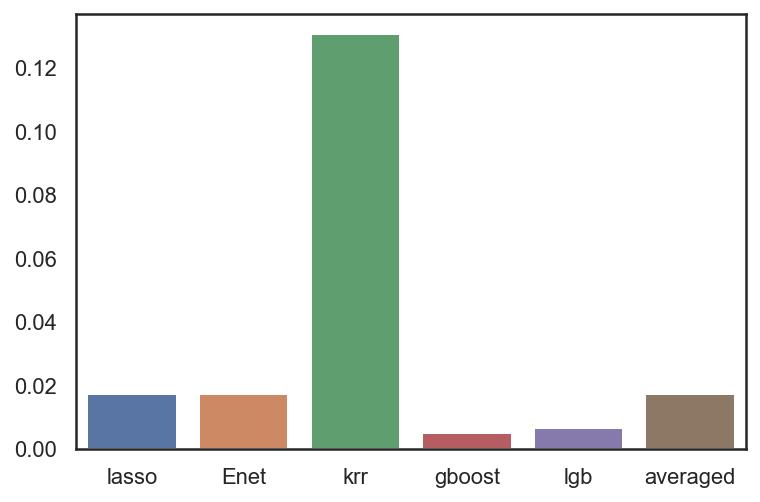

In [64]:
# # Mean Squared Error (MSE) Evaluation
# MSE_results = []
# for model in models:
#     MSE_results.append(mean_squared_error(y_test, model.predict(test.values)))
# sns.barplot(names, MSE_results)

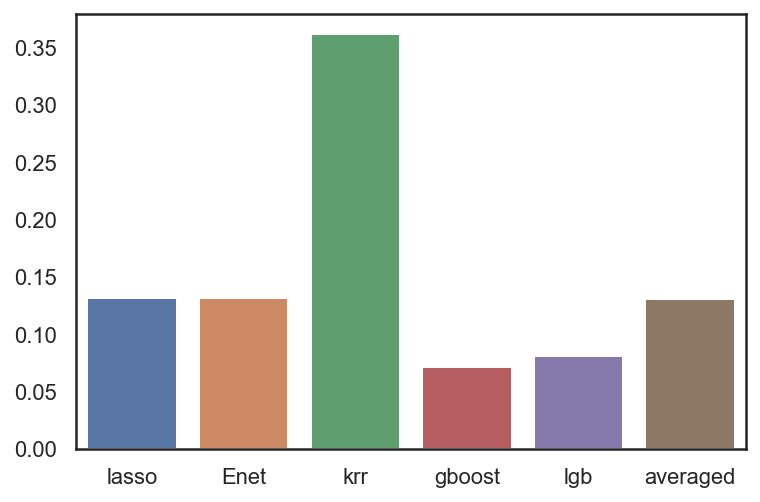

In [65]:
# # Root Mean Squared Error (RMSE) Evaluation
# RMSE_results = []
# for model in models:
#     RMSE_results.append(np.sqrt(mean_squared_error(y_test, model.predict(test.values))))
# sns.barplot(names, RMSE_results)

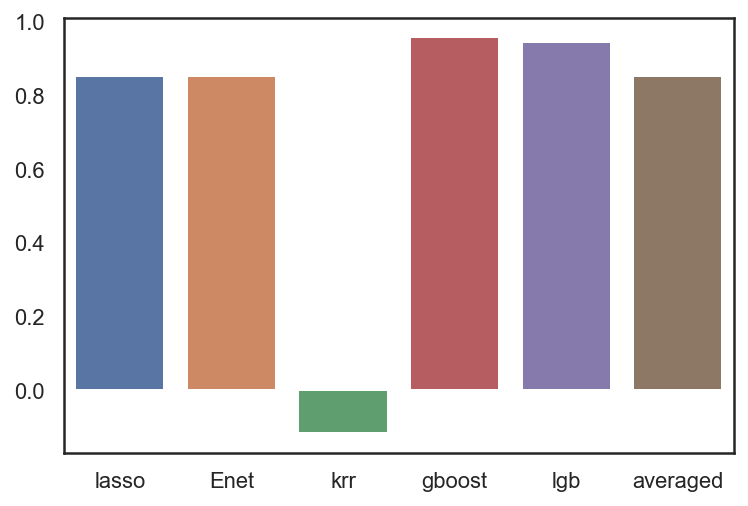

In [66]:
# # R2 Evaluation
# r2_results = []
# adjusted_r2_results = []
# p = df.shape[1]
# n = y_test.shape[0]
# for model in models:
#     r2 = r2_score(y_test, model.predict(test.values))
#     r2_results.append(r2)
#     adjusted_r2_results.append(1-(1-r2)*((n-1)/(n-p-1)))
# sns.barplot(names, r2_results)

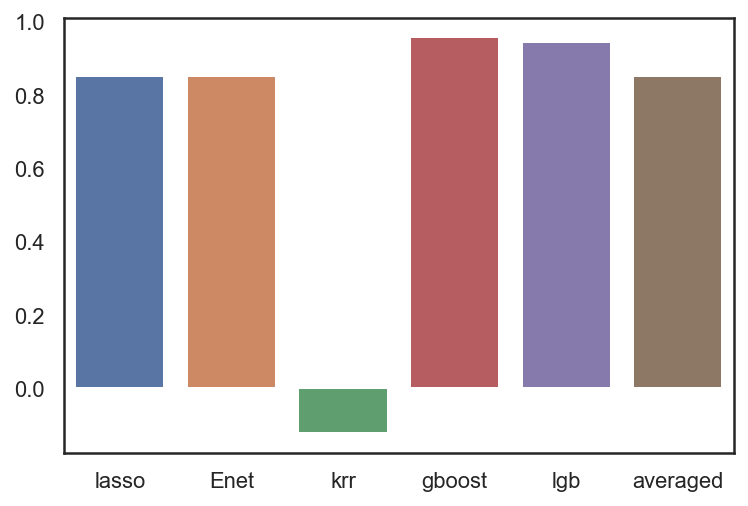

In [67]:
# # Adjusted R2 Evaluation
# # https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
# # p is the total number of explanatory variables in the model (not including the constant term), and n is the sample size.

# sns.barplot(names, adjusted_r2_results)